# Learning Gate - Reto

## Analítica de texto aplicada al estudio de sentimientos para la toma de decisiones

### Data Science Descriptive Analysis - Visualizations

## Objetivo:

Construir un corpus utilizando las herramientas que has practicado a lo largo del módulo y realizar las siguientes actividades: calcular las frecuencias de longitudes de texto, frecuencias de palabras más comunes y extensión de vectores de stopwords. Realizar las operaciones de procesamiento básico de textos: tokenizar, aplicar stemming, remover stopwords. 

Crear gráficas para exploración de textos: histogramas, resumen de sentimientos, t-SNE o WordClouds. Implementar y aplicar el análisis de sentimientos a los textos que se han recopilado en el corpus.

### Importing Libraries

In [43]:
import os, glob, math, torch, json, nltk, random
import regex as re
from collections import Counter
import pandas as pd
import numpy as np
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.manifold import TSNE
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="sentiment", lang="en")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfde\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\alfde\Developments\DataProcessing\Enviroments\Pytorch\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Loading Data

In [2]:
path = os.path.join(os.getcwd(), 'Data')
files = glob.glob(os.path.join(path, '*.json'))

df = pd.read_json(files[0], lines=True)

## Exploratory Data Analysis

### Characteristics of the Loaded Data

#### Information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997140 entries, 0 to 1997139
Data columns (total 12 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   _id             object
 1   reviewerID      object
 2   asin            object
 3   reviewerName    object
 4   helpful         object
 5   reviewText      object
 6   overall         int64 
 7   summary         object
 8   unixReviewTime  int64 
 9   reviewTime      object
 10  category        object
 11  class           int64 
dtypes: int64(3), object(9)
memory usage: 182.8+ MB


#### Null values within the loaded data

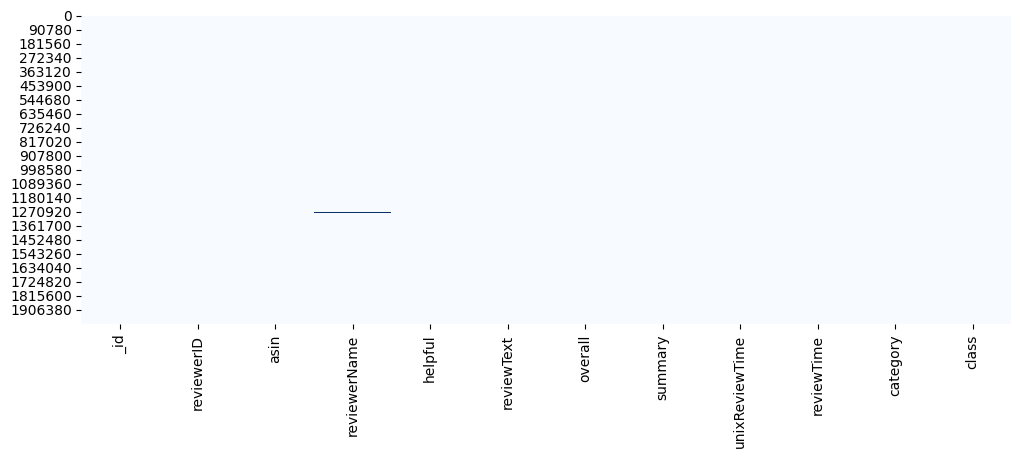

In [4]:
#Investigate patterns in the amount of missing values in the dataframe columns
fig, ax = plt.subplots(figsize=(12,4))  
sns.heatmap(df.isnull(), cbar=False,cmap="Blues", ax=ax);

- ***Removing Null Values***

In [5]:
df.dropna(inplace=True)

### Processing the loaded Data

#### Defining Functions to process the data

In [7]:
lemmatizer = WordNetLemmatizer()

def tokenizer(texto):
    return re.findall(r'[\w-]*\p{L}[\w-]*', texto)
    
def quita_stopword(palabras):
    return [lemmatizer.lemmatize(palabra) for palabra in palabras if palabra.lower() not in stopwords]

def crea_corpus(textos):
    corpus=[]
    textos=textos.values.tolist()
    corpus=[palabra.lower() for oracion in textos for palabra in oracion]
    corpus = quita_stopword(corpus)
    return corpus

def obtenProbabilidades(tweets_candidato, sentimientos):
  negativos = []
  neutros = []
  positivos =[]
  for probabilidad in sentimientos:
    negativos.append(probabilidad.probas['NEG'])
    neutros.append(probabilidad.probas['NEU'])
    positivos.append(probabilidad.probas['POS'])
  probabilidades = {'negativos': negativos, 'neutros': neutros, 'positivos':positivos}
  probabilidades = pd.DataFrame.from_dict(probabilidades)
  return pd.concat([tweets_candidato, probabilidades.reindex(tweets_candidato.index)], axis=1)

def calculaNGrams(corpus, colors, n=None, limit=10, ax=ax):

    vector_grams = CountVectorizer(ngram_range=(n, n)).fit(corpus) 

    bolsa_de_palabras = vector_grams.transform(corpus) 

    sumatoria_palabras = bolsa_de_palabras.sum(axis=0) 

    frecuencias_palabras = [(palabra, sumatoria_palabras[0, indice]) 

        for palabra, indice in vector_grams.vocabulary_.items()] 

    frecuencias_palabras =sorted(frecuencias_palabras, key = lambda x: x[1], reverse=True) 

    x,y=map(list,zip(*frecuencias_palabras[:limit])) 

    sns.barplot(x=y,y=x, ax=ax, color = colors)

def nube_palabras(corpus, stopwords, ax, color):
    stopwords = set(stopwords)
    wordcloud = WordCloud(
    background_color=color,
    stopwords=stopwords,
    max_words=100,
    max_font_size=45,
    scale=3,
    random_state=1)
    wordcloud=wordcloud.generate(str(corpus))
    #fig = plt.figure(1, figsize=(15, 15))
    ax.imshow(wordcloud)
#plt.show()

#### Sentiment Analysis

Sentiment Analysis Overview

After exploring the features of the loaded data, it appears that the class variable may correspond to positive and negative purchase reviews. This insight is crucial for understanding the characteristics of the dataset and will be important when presenting conclusions after any implemented analysis.

To effectively analyze the sentiment of these reviews, a sentiment analysis will be conducted using the *pysentimiento* library, as outlined below:

- ***Getting Sentiment Probabilities for Purchase Reviews***

Given the large volume of reviews in the dataset and limited computational resources, randomly selected samples were used for the following analysis. These samples allowed for efficient sentiment probability calculations while maintaining the integrity of the overall analysis.

In [8]:
df_tmp = pd.concat([df[df['class']==1].sample(100), df[df['class']==0].sample(100)])
df_tmp.reset_index(drop=True, inplace=True)
df_tmp = df_tmp[['reviewerID', 'reviewText', 'overall', 'summary', 'reviewTime', 'class']]

df_sentiments =  obtenProbabilidades(df_tmp, analyzer.predict(df_tmp.reviewText))

display(df_sentiments.sample(5))

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

c:\Users\alfde\Developments\DataProcessing\Enviroments\Pytorch\lib\site-packages\transformers\models\roberta\modeling_roberta.py:370: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


,reviewerID,reviewText,overall,summary,reviewTime,class,negativos,neutros,positivos
166,A1SQHNRR4E9O42,These feathers are extremely thin and worthle...,1,thin and crappy!,"06 4, 2014",0,0.703839,0.279108,0.017053
73,ASY25YMTIC2A9,I got these for my daughters who love to play ...,4,Simple but entertaining,"12 16, 2013",1,0.004074,0.097982,0.897944
120,A1DAONXMNFLY5X,When we received the item the ears were broken...,3,Broken but so much fun!,"01 2, 2014",0,0.076395,0.281509,0.642096
182,A3FX2XY1K1PJP9,two of the lights did not work when we receive...,2,E lights,"07 31, 2013",0,0.971814,0.025645,0.002541
113,A1O5TVTKYL466F,so I bought this for 2 of my kids who 1- used ...,1,will use it once and never again,"03 13, 2014",0,0.410392,0.557891,0.031717


- ***Analyzing Similarities between the Class Variable and Sentiment Analysis Results***

Upon comparison, it is evident that positive comments are predominantly associated with instances where the class variable equals 1. Conversely, the remaining elements of the class variable are largely linked to negative sentiment. However, a notable proportion of these elements are also associated with other sentiments, indicating a degree of variability in sentiment classification.

In [9]:
df_sentiments.groupby('class')[['negativos', 'neutros', 'positivos']].agg(['mean'])

,negativos,neutros,positivos
,mean,mean,mean
class,,,
0,0.582260,0.204878,0.212862
1,0.021544,0.079346,0.899109


#### Creating Corpora from Purchase Reviews in the Loaded Data

Based on the results of the previous sentiment analysis, it was determined that two distinct corpora need to be generated. One corpus will consist of positive reviews, while the other will include non-positive reviews. These corpora will be used for further analysis, as outlined below:

In [10]:
# Poritive
corpus_pos =[crea_corpus(df[df['class']==1]['reviewText'].map(lambda oracion: tokenizer(oracion)))]
# Non-positive
corpus_neg =[crea_corpus(df[df['class']==0]['reviewText'].map(lambda oracion: tokenizer(oracion)))]

#### Bag of Words

In this section, a Bag of Words model is implemented for both positive and non-positive reviews. The objective is to identify common words associated with each sentiment, which will then be visualized in the next section to provide insights into the language patterns related to different sentiments.

In [13]:
# Positive BoW
counts_pos = Counter(corpus_pos[0])
counts_pos = {k: v for k, v in sorted(counts_pos.items(), key=lambda item: item[1], reverse=True)}
# Non-Positive BoW
counts_neg = Counter(corpus_neg[0])
counts_neg = {k: v for k, v in sorted(counts_neg.items(), key=lambda item: item[1], reverse=True)}

print('Example for positive sentiments: \n', [(key, counts_pos[key]) for i, key in enumerate(counts_pos.keys()) if i<=5])

Example for positive sentiments: 
 [('love', 660480), ('great', 548008), ('one', 534291), ('game', 458838), ('toy', 434526), ('like', 400952)]


#### TF-IDF

The TF-IDF algorithm was applied to determine word importance within positive reviews only. This is an exploratory analysis, aiming to identify key terms that are particularly relevant to positive sentiment. As a complement to this, a comparative analysis of word importance between both positive and non-positive sentiments is presented in the following section.

In [14]:
# definición del Vector tf-idf:
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
# "entrenamiento" de tf-idf:
tfIdf = tfIdfVectorizer.fit_transform([' '.join(corpus_pos[0][:])])
# extracción de las palabras y los valores de tf-idf:
df_tfidf = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names_out(), columns=["tf-idf"])
# ordenamiento de las palabras obtenidas:
df_tfidf = df_tfidf.sort_values('tf-idf', ascending=False)
# impresión de los datos tf-idf:
print (df_tfidf.head(25))

            tf-idf
love      0.291752
great     0.243222
one       0.237545
game      0.203615
toy       0.192411
old       0.189089
like      0.179097
year      0.178788
play      0.153654
little    0.147901
fun       0.143762
would     0.138639
get       0.136186
well      0.134325
time      0.130262
good      0.126588
kid       0.119593
really    0.117499
bought    0.114102
set       0.113745
son       0.112772
daughter  0.103596
make      0.094098
got       0.090181
also      0.089224


#### Creating a Word2Vec Deep Learning Model to Analyze Reviews

The Word2Vec algorithm is employed to capture word meanings within defined contexts, represented by vectors composed of surrounding words or their context. Additionally, the results from this algorithm will be used to identify similarities between words in the loaded reviews. These relationships will be visualized in the next section using plots to provide insights into word associations and their meanings within the dataset.

- ***Creating the word2vect Model***

In [33]:
modelo_pos = word2vec.Word2Vec(corpus_pos, vector_size=100, window=10, min_count=10)
modelo_neg = word2vec.Word2Vec(corpus_neg, vector_size=100, window=10, min_count=10)
print(modelo_pos)

Word2Vec<vocab=45703, vector_size=100, alpha=0.025>


- ***Example of similarities among words related to positive sentiment reviews***

In [34]:
word2review = corpus_pos[0][random.randint(0, len(corpus_pos[0]))]
similares= modelo_pos.wv.most_similar(word2review, topn=10)
print('Similudues for the word: {} '.format(word2review), '\n')
display(pd.DataFrame(similares, columns=['Word2Review', 'Similitude_with_{}'.format(word2review)]))

Similudues for the word: sure  



,Word2Review,Similitude_with_sure
0,best,0.982250
1,different,0.981443
2,time,0.981348
3,page,0.981169
4,help,0.981088
5,coloring,0.981081
6,see,0.981071
7,one,0.981050
8,easy,0.981042
9,game,0.981026


### Visualizations

In this section, visualizations will be utilized to uncover insights based on the purchase reviews that make up the loaded data. These visualizations will draw from the previous sections to illustrate relationships among the key characteristics of the purchase reviews.

#### Histograms

The following figure presents the distributions related to the lengths of reviews associated with positive and non-positive sentiments. It is observed that non-positive reviews tend to be slightly longer than positive reviews. Both distributions of text lengths exhibit characteristics resembling Gaussian processes.

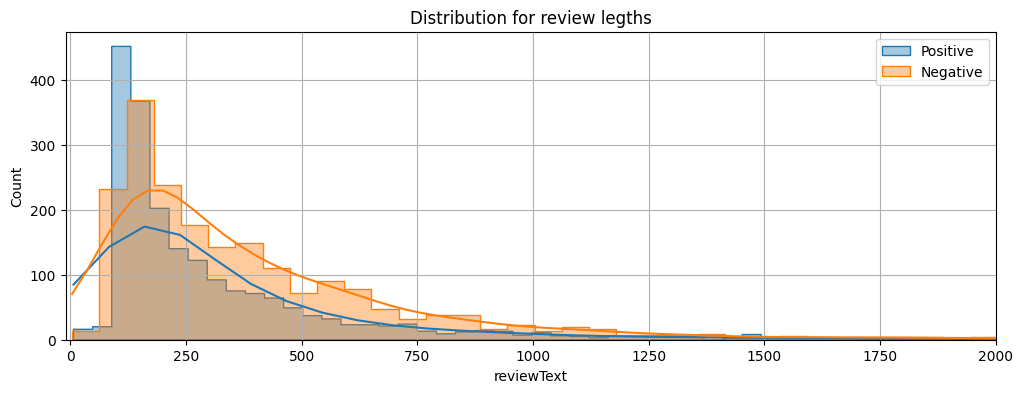

In [26]:
fig, ax = plt.subplots(figsize=(12,4))  
#sns.histplot(df.sample(1000)['reviewText'].str.len(), alpha=.4, element="step", hue='class', ax=ax)
sns.histplot(df[df['class']==1].sample(2000)['reviewText'].str.len(), kde=True, ax=ax, alpha=.4, element="step", label='Positive')
sns.histplot(df[df['class']==0].sample(2000)['reviewText'].str.len(), kde=True, ax=ax, alpha=.4, element="step", label='Negative')
ax.set_xlim([-10, 2000]);
plt.title('Distribution for review legths')
plt.legend();
plt.grid()

#### Most Common Words

In this section, the previously generated Bag of Words (BoW) for both positive and non-positive sentiments in the purchase reviews is utilized to explore the differences between the two. The most common words identified in each sentiment are presented below:

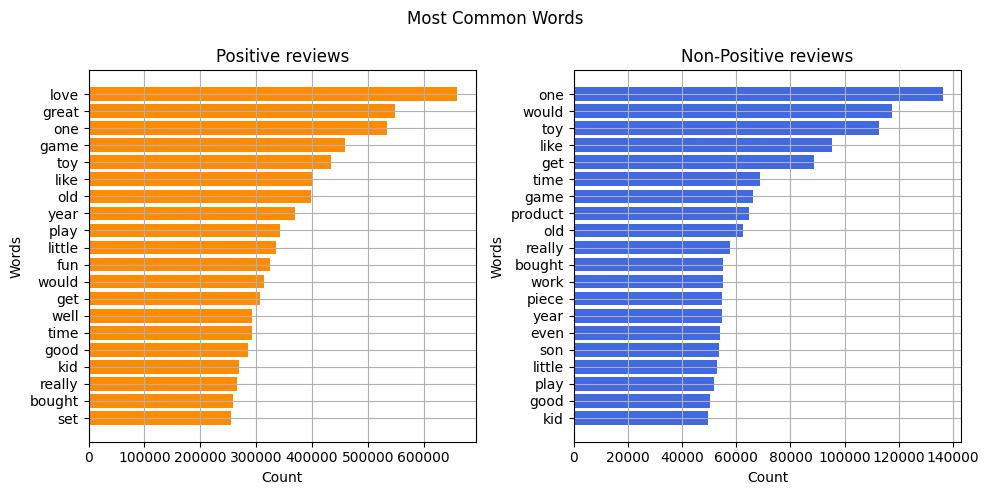

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,5))  
lim = 20
axs[0].barh(list(counts_pos.keys())[0:lim][::-1], list(counts_pos.values())[0:lim][::-1], color='darkorange')
axs[0].set_title('Positive reviews')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Words')
axs[0].grid()
axs[1].barh(list(counts_neg.keys())[0:lim][::-1], list(counts_neg.values())[0:lim][::-1], color='royalblue')
axs[1].set_title('Non-Positive reviews')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Words')
axs[1].grid()
plt.suptitle('Most Common Words')
fig.tight_layout()

#### Most Common N(2)-Grams

The following figure presents the most common relationships between words for each sentiment of the analyzed reviews. These word relationships are known as n-grams, where n represents the number of words in each relationship. In the next figure, the most common bi-grams (2-grams) for positive and non-positive reviews are displayed.

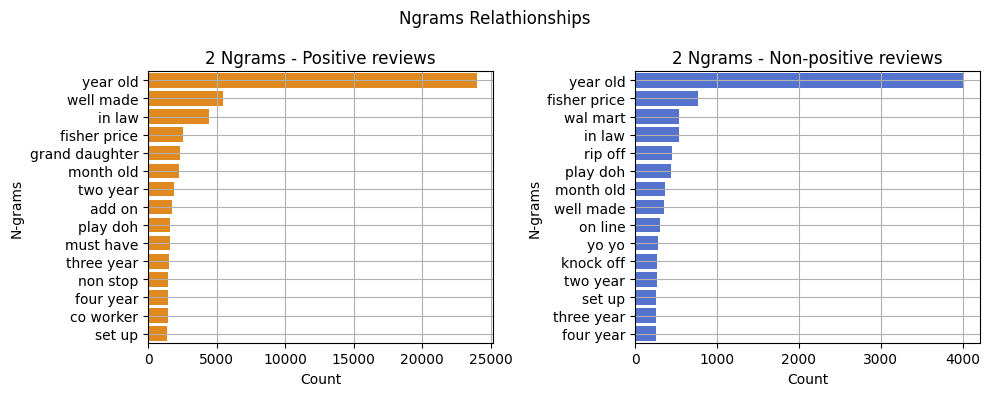

In [30]:
fig, axs = plt.subplots(1,2, figsize=(10,4))  
ngrams = 2
calculaNGrams(corpus_pos[0], "darkorange", ngrams, 15, axs[0])
axs[0].set_title('{} Ngrams - Positive reviews'.format(ngrams))
axs[0].set_xlabel('Count')
axs[0].set_ylabel('N-grams')
axs[0].grid()
calculaNGrams(corpus_neg[0], "royalblue", ngrams, 15, axs[1])
axs[1].set_title('{} Ngrams - Non-positive reviews'.format(ngrams))
axs[1].set_xlabel('Count')
axs[1].set_ylabel('N-grams')
axs[1].grid()
plt.suptitle('Ngrams Relathionships')
fig.tight_layout()

#### Cloud of Words

The following figures present the importance of words within the generated corpora related to positive and negative purchase reviews. In these figures, the size of each word represents its significance within the respective text.

Text(0.5, 1.0, 'Most Common Non-Positive Related Words')

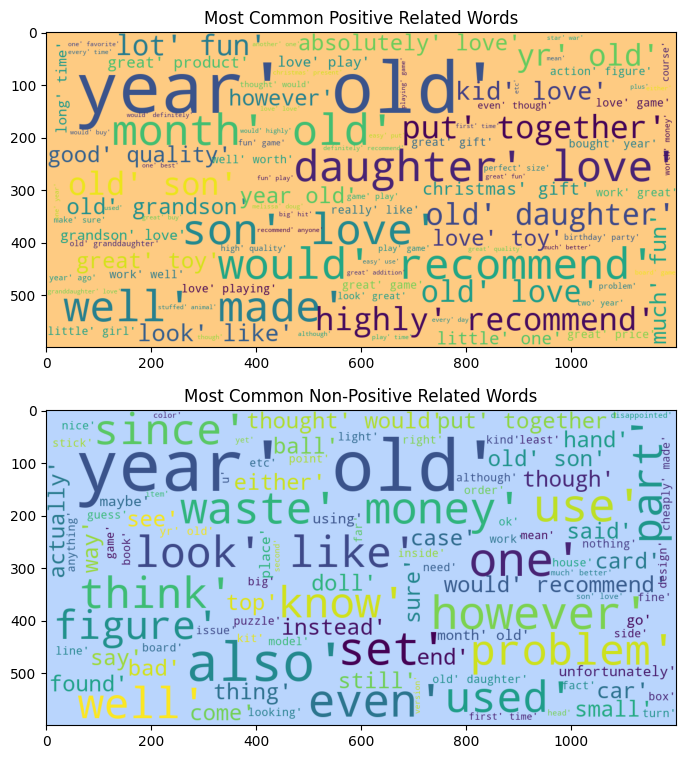

In [31]:
fig, axs = plt.subplots(2,1, figsize=(10,9))  
nube_palabras(corpus_pos, stopwords, axs[0], '#fecb82')
axs[0].set_title('Most Common Positive Related Words')
nube_palabras(corpus_neg, stopwords, axs[1], '#b9d5fd')
axs[1].set_title('Most Common Non-Positive Related Words')

#### Word Similarities Based on Word2Vec

In this subsection, we present the similarities among words related to positive and non-positive sentiments. The similarities between the mentioned words for both cases are determined by the distance between the points representing each word in the Word2Vec model. The closer the points are to each other, the stronger the similarity between the two words is in relation to the purchase reviews.

- ***Positive Reviews***

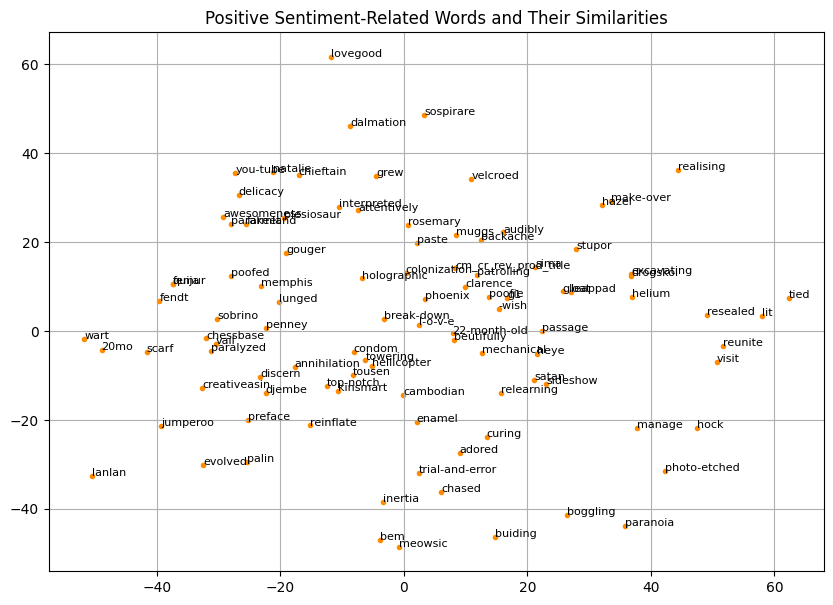

In [41]:
vocab = list(modelo_pos.wv.key_to_index)
X = modelo_pos.wv[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df_w2v = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df_test = df_w2v.sample(100)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_test['x'], df_test['y'], marker='.', color='darkorange')
ax.set_xlabel
ax.grid()
ax.set_title('Positive Sentiment-Related Words and Their Similarities')

for word, pos in df_test.iterrows():
    ax.annotate(word, pos, fontsize=8)

- ***Non-Positive Reviews***

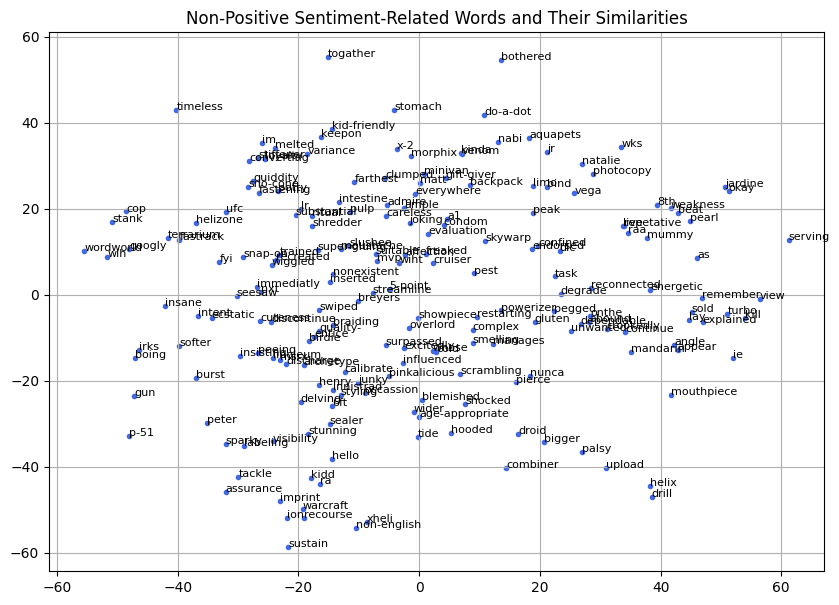

In [42]:
vocab = list(modelo_neg.wv.key_to_index)
X = modelo_neg.wv[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

df_w2v = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df_test = df_w2v.sample(200)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_test['x'], df_test['y'], marker='.', color='royalblue')
ax.set_xlabel
ax.grid()
ax.set_title('Non-Positive Sentiment-Related Words and Their Similarities')

for word, pos in df_test.iterrows():
    ax.annotate(word, pos, fontsize=8)

## Conclusions

In conclusion, the application of NLP techniques has enabled us to identify key factors influencing customer sentiment toward products, specifically toys and games. These factors play a significant role in either enhancing or diminishing customers' enthusiasm for acquiring these items and, consequently, their willingness to continue purchasing or relying on associated brands.

However, the analysis was limited by the computational resources available due to the large volume of cases within the provided dataset. Additionally, the dataset contains a feature named "class," which could potentially reduce the need for extensive computational resources by offering a metric related to customer sentiment when acquiring a toy or game. It is important to note, though, that only instances related to the class value of 1 are deemed reliable, as the other class cases encompass positive, negative, and neutral sentiments, which diminishes the clarity of insights that can be extracted from that variable.

Nonetheless, this is just a preliminary approach to what can be achieved using NLP techniques. The next step is to leverage more computational resources and implement recurrent neural networks (RNNs) to develop models that can predict potential customer reviews based on the characteristics of toys or games. This will provide a reliable metric for assessing the potential success of a product in the market.

# FIN